# Imports and Defaults

In [15]:
import os

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import norm
import seaborn as sns

from src.utils.summary_utils import read_from_summary

In [16]:
%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# defaults I set

posterior = "stochastic_volatility"
hyper_param = "sampler_type"
tags_list = ["drghmc-baseline", "drhmc-baseline", "hmc-baseline", "nuts-baseline"]

if posterior == "funnel10":
    error_params = ["error_log_scale", "error_log_scale_squared", "error_latent", "error_latent_squared"]
else:
    error_params = ["error_param", "error_param_squared"]

# Load Data

In [18]:
path = os.path.join("data", posterior, "summary.csv")
summary_lazy = pl.scan_csv(path, has_header=True)

# cast a few columns to specifc polars data types
summary_lazy = summary_lazy.with_columns(
    pl.col("step_size").cast(pl.Float32),
    pl.col("step_size_factor").cast(pl.Float32),
    pl.col("step_count").cast(pl.Int32),
    pl.col("step_count_factor").cast(pl.Float32),
    pl.col("max_proposals").cast(pl.Int32),
    pl.col("reduction_factor").cast(pl.Float32),
    pl.col("damping").cast(pl.Float32),
)

In [19]:
# filter by the tags and then sort according to the hyper_param
summary = summary_lazy.filter(
    (pl.col("tags") == tags_list[0]) | (pl.col("tags") == tags_list[1]) | (pl.col("tags") == tags_list[2]) | (pl.col("tags") == tags_list[3])
).sort(
    pl.col(hyper_param),
).collect()
summary.describe()

statistic,sampler_type,tags,error_param,error_param_squared,error_log_scale,error_log_scale_squared,error_latent,error_latent_squared,group,step_count_factor,step_count,step_count_method,step_size_factor,step_size,max_proposals,reduction_factor,damping,metric,adapt_metric,probabilistic,chain,history_path,metric_path
str,str,str,f64,f64,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str
"""count""","""201""","""201""",201.0,201.0,"""0""","""0""","""0""","""0""","""201""",67.0,0.0,"""67""",134.0,0.0,134.0,134.0,134.0,"""201""",201.0,134.0,201.0,"""201""","""201"""
"""null_count""","""0""","""0""",0.0,0.0,"""201""","""201""","""201""","""201""","""0""",134.0,201.0,"""134""",67.0,201.0,67.0,67.0,67.0,"""0""",0.0,67.0,0.0,"""0""","""0"""
"""mean""",null,null,1.721921,2.568895,null,null,null,null,null,0.9,null,null,2.0,null,3.0,4.0,0.54,null,1.0,0.0,33.0,null,null
"""std""",null,null,2.469041,3.976116,null,null,null,null,null,0.0,null,null,0.0,null,0.0,0.0,0.461726,null,null,null,19.387367,null,null
"""min""","""drghmc""","""drghmc-baselin…",0.022738,0.021589,null,null,null,null,"""adapt_metric=T…",0.9,null,"""const_step_cou…",2.0,null,3.0,4.0,0.08,"""1""",1.0,0.0,0.0,"""/mnt/home/gtur…","""/mnt/home/gtur…"
"""25%""",null,null,0.037718,0.038195,null,null,null,null,null,0.9,null,null,2.0,null,3.0,4.0,0.08,null,null,null,16.0,null,null
"""50%""",null,null,0.087961,0.084995,null,null,null,null,null,0.9,null,null,2.0,null,3.0,4.0,1.0,null,null,null,33.0,null,null
"""75%""",null,null,3.930351,4.983762,null,null,null,null,null,0.9,null,null,2.0,null,3.0,4.0,1.0,null,null,null,50.0,null,null
"""max""","""nuts""","""nuts-baseline""",8.177918,16.359656,null,null,null,null,"""adapt_metric=T…",0.9,null,"""const_step_cou…",2.0,null,3.0,4.0,1.0,"""identity""",1.0,0.0,66.0,"""/mnt/home/gtur…","""/mnt/home/gtur…"


In [20]:
hyper_params_order = summary[hyper_param].unique().sort().to_numpy()

# Table

In [22]:
for c in error_params:
    grouped = summary.group_by("group").agg(
        pl.first("sampler_type").alias("sampler_type"),
        pl.first(hyper_param).alias(hyper_param) if hyper_param != "sampler_type" else None,
        pl.mean(c).alias("mean"),
        pl.std(c).alias("std"),
        pl.median(c).alias("median"),
    ).sort(hyper_param)
    
    markdown = grouped.to_pandas().to_markdown(tablefmt="simple_outline")
    print(c)
    print(markdown)
    print("\n\n")

error_param
┌────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────┬───────────┬───────────┬────────────┬───────────┐
│    │ group                                                                                                                                                                            │ sampler_type   │ literal   │      mean │        std │    median │
├────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┼───────────┼───────────┼────────────┼───────────┤
│  0 │ adapt_metric=True__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2 │ drghmc         │           │ 0.0962698 │ 0.031

# Box Plot and Point Plot

In [23]:
value_vars = error_params
id_vars = [col for col in summary.columns if col not in value_vars]
melted = summary.melt(id_vars=id_vars, value_vars=value_vars, variable_name="param", value_name="normalized error")

data = pd.DataFrame(melted.to_pandas())

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Normalized Error for stochastic_volatility Posterior')

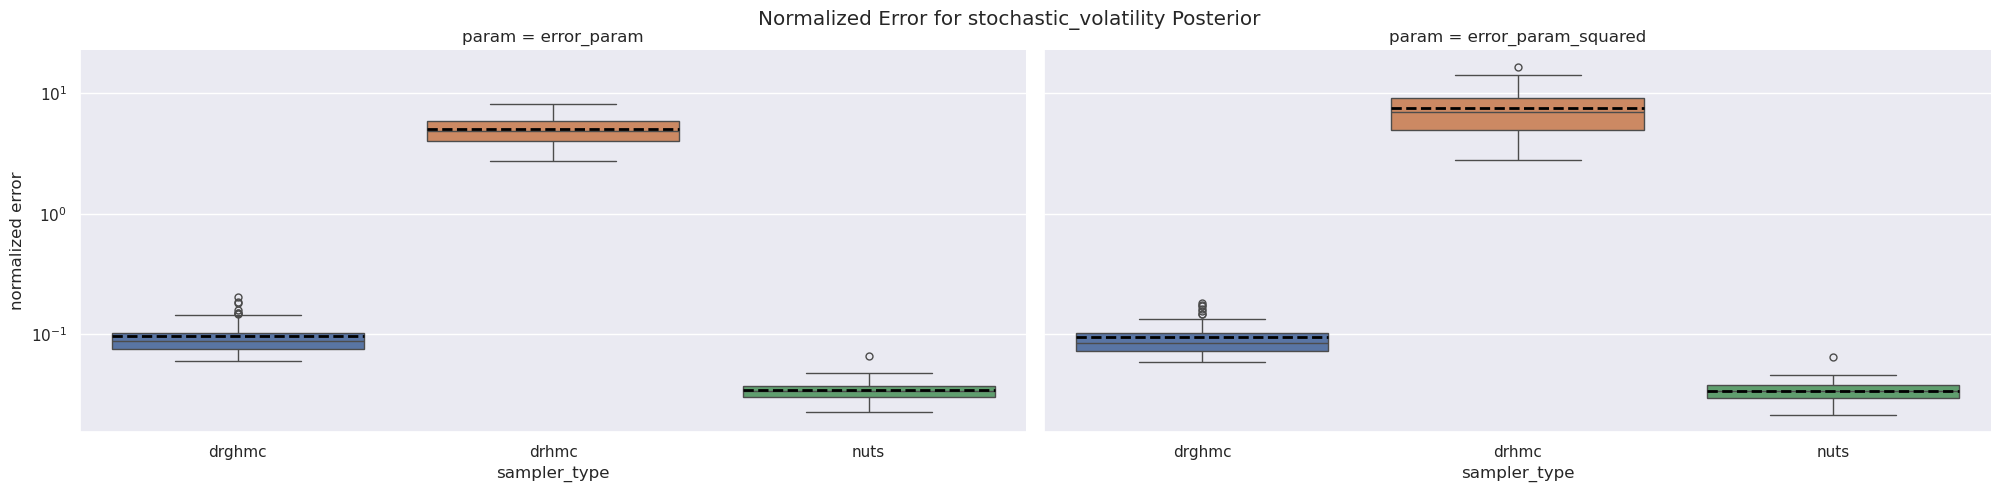

In [24]:
fig = sns.catplot(
    data=data,
    kind="box",
    x=hyper_param,
    y="normalized error",
    hue="sampler_type",
    # hue_order=hyper_param_order,
    col="param",
    col_wrap=2,
    col_order=value_vars,
    aspect=2,
    showmeans=True,
    meanline=True,
    meanprops=dict(linestyle="--", linewidth=2, color="black"),
)

# set y axis to log scale
fig.set(yscale="log")

# add title and make room for it
fig.figure.subplots_adjust(top=0.9)
fig.figure.suptitle(f"Normalized Error for {posterior} Posterior")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Normalized Error for stochastic_volatility Posterior')

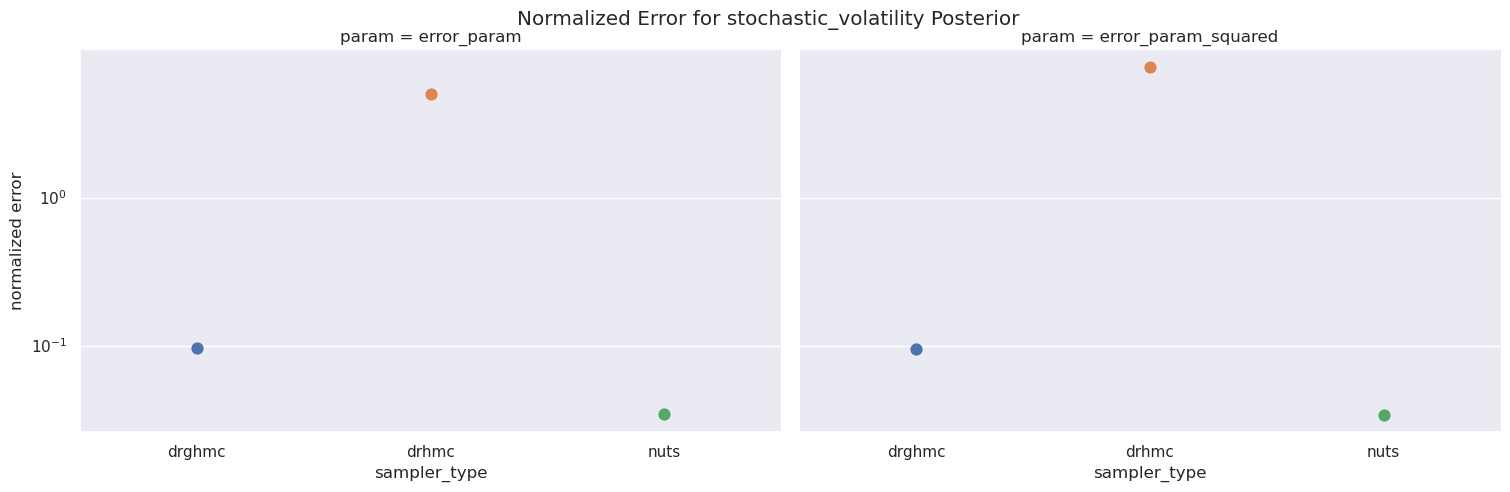

In [25]:
fig = sns.catplot(
    data=data,
    kind="point",
    x=hyper_param,
    y="normalized error",
    hue="sampler_type",
    estimator=np.mean,
    errorbar=None,
    col="param",
    col_wrap=2,
    col_order=value_vars,
    aspect=1.5,
)

fig.set(yscale="log")

fig.figure.subplots_adjust(top=0.9)
fig.figure.suptitle(f"Normalized Error for {posterior} Posterior")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Normalized Error on stochastic_volatility Posterior')

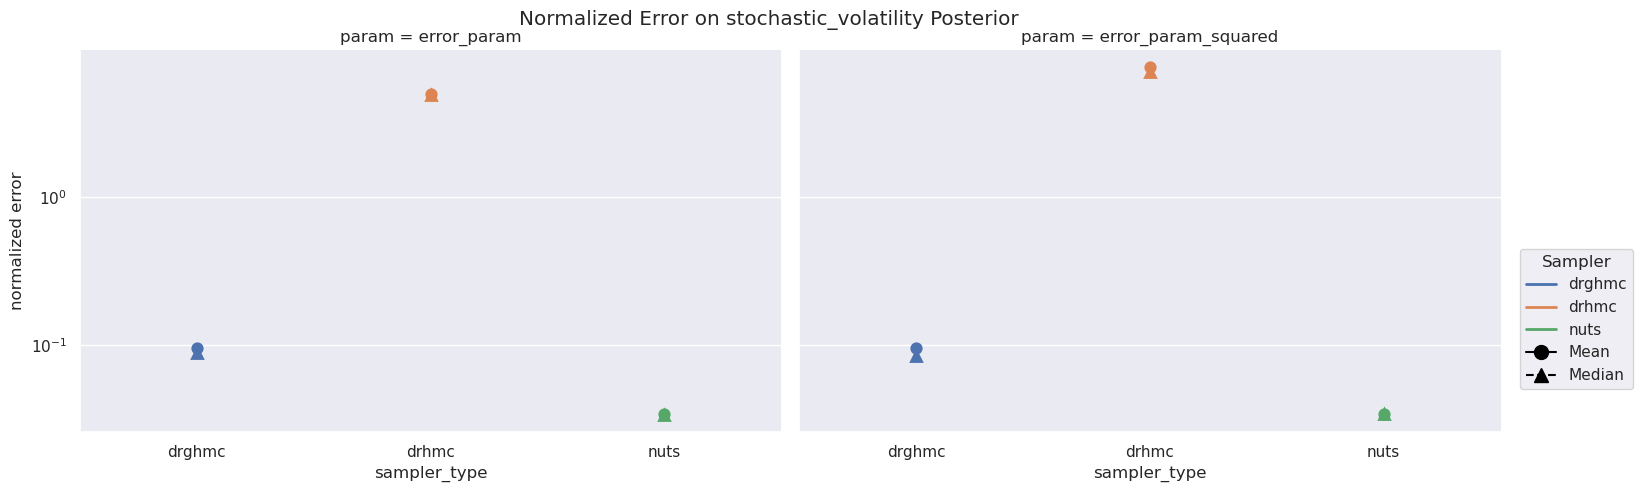

In [26]:
g = sns.FacetGrid(data=data, hue="sampler_type", col="param", col_wrap=2, col_order=value_vars, aspect=1.5, height=5)
g.map(sns.pointplot, hyper_param, "normalized error", estimator=np.mean, errorbar=None, markers="o", order=hyper_params_order)
g.map(sns.pointplot, hyper_param, "normalized error", estimator=np.median, errorbar=None, markers="^", order=hyper_params_order, err_kws={"linestyle": "-"}, linestyle="--")
g.set(yscale="log")

hues = data["sampler_type"].unique()
custom_legend = [Line2D([0], [0], color=sns.color_palette()[i], lw=2, label=hue) for i, hue in enumerate(hues)]
custom_legend += [
    Line2D([0], [0], marker="o", color="black", markerfacecolor="black", markersize=10, label="Mean"),
    Line2D([0], [0], marker="^", color="black", markerfacecolor="black", markersize=10, label="Median", linestyle="--"),
]

plt.legend(handles=custom_legend, loc="upper right", bbox_to_anchor=(1.2, 0.5), ncol=1, title="Sampler") # legend to the right of figure
# plt.legend(handles=custom_legend, loc="lower center", bbox_to_anchor=(0, -0.3), ncol=3) # legend below figure

g.figure.subplots_adjust(top=0.9)
g.figure.suptitle(f"Normalized Error on {posterior} Posterior")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Normalized Error for stochastic_volatility Posterior')

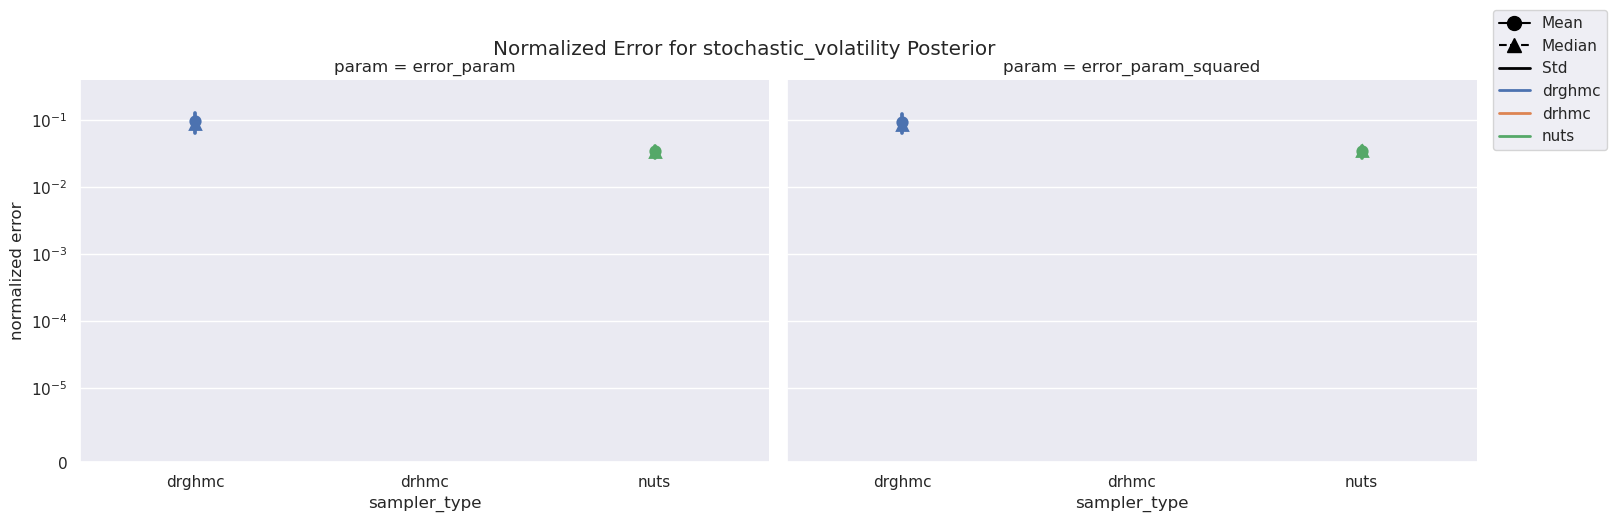

In [27]:
g = sns.FacetGrid(
    data=data, hue="sampler_type", col="param", col_wrap=2, col_order=value_vars, aspect=1.5, height=5, ylim=(0, 0.4)
)

g.map(sns.pointplot, hyper_param, "normalized error", estimator=np.mean, errorbar="sd", markers="o", order=hyper_params_order, dodge=True, linestyle="none")
g.map(sns.pointplot, hyper_param, "normalized error", estimator=np.median, errorbar=None, markers="^", order=hyper_params_order, err_kws={"linestyle": "--"}, linestyle="none", dodge=True)

for ax in g.axes.flat:
    ax.set_yscale('symlog', linthresh=1e-5)

custom_legend = [
    Line2D([0], [0], marker="o", color="black", markerfacecolor="black", markersize=10, label="Mean"),
    Line2D([0], [0], marker="^", color="black", markerfacecolor="black", markersize=10, label="Median", linestyle="--"),
    Line2D([0], [0], color="black", linewidth=2, linestyle="-", label="Std"),
]
custom_legend += [Line2D([0], [0], color=sns.color_palette()[i], lw=2, label=hue) for i, hue in enumerate(hues)]

plt.legend(handles=custom_legend, loc="center right", bbox_to_anchor=(1.2, 1), ncol=1) # legend to the right of figure
# plt.legend(handles=custom_legend, loc="lower center", bbox_to_anchor=(0, -0.3), ncol=3) # legend below figure

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Normalized Error for {posterior} Posterior")

# Cost vs Grad Evals

In [28]:
history_list = ["grad_evals"]
metrics_list = error_params
n_samples = None # None for all samples
complete_summary = read_from_summary(summary, history_list, metrics_list, n_samples)

In [29]:
grad_rounding = -3
complete_summary = complete_summary.with_columns(
    pl.col("grad_evals").map_elements(lambda s: np.round(s, grad_rounding)).alias("gradient evaluations")
)

In [30]:
value_vars = error_params
id_vars = [col for col in complete_summary.columns if col not in value_vars]
melted = complete_summary.melt(id_vars=id_vars, value_vars=value_vars, variable_name="params", value_name="normalized error")

data = melted.to_pandas()

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Mean Normalized Error vs Gradient Evaluations for stochastic_volatility Posterior')

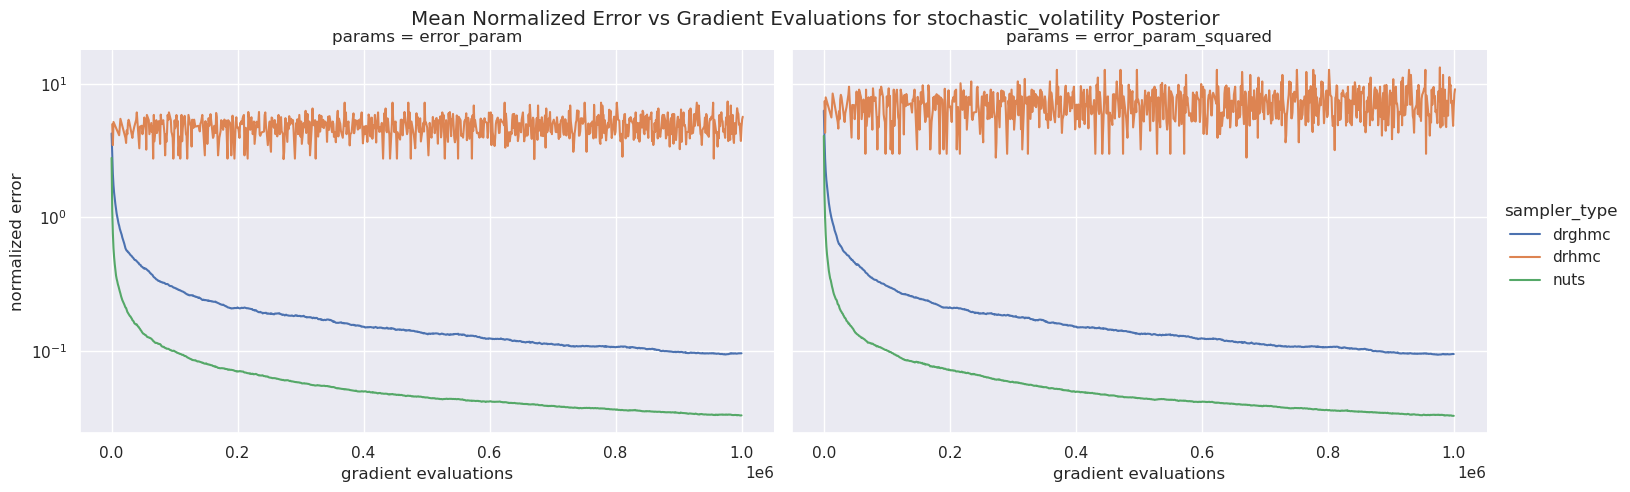

In [31]:
fig = sns.relplot(
    data=data,
    kind="line",
    x="gradient evaluations",
    y="normalized error",
    hue=hyper_param,
    hue_order=hyper_params_order,
    style="sampler_type" if hyper_param != "sampler_type" else None,
    errorbar=None,
    estimator="mean",
    col="params",
    col_wrap=2,
    col_order=value_vars,
    aspect=1.5,
)

fig.set(yscale="log")
fig.figure.subplots_adjust(top=0.9)
fig.figure.suptitle(f"Mean Normalized Error vs Gradient Evaluations for {posterior} Posterior")

# Log Scale Param

In [63]:
history_list = ["grad_evals", "draws"]
metrics_list = [error_params[0]]
n_samples = -1

complete_summary = read_from_summary(summary, history_list, metrics_list, n_samples)
data = complete_summary.to_pandas()

: 

In [ ]:
fig = sns.displot(
    data=data,
    kind="hist",
    x="p0",
    hue=hyper_param,
    hue_order=hyper_params_order,
    stat="density",
    element="step",
    common_norm=False,
    common_bins=False,
    aspect=4,
    fill=False,
)

x = np.linspace(-12, 12, 1000)
y = norm.pdf(x, loc=0, scale=3) # normal(0, 3)
for fig in fig.fig.axes:
    fig.plot(x, y, label="Ref Draws", color="black", linewidth=1, linestyle="--")
    fig.legend(loc="upper right")
    
fig.set(xlim=(-12, 12))
fig.figure.subplots_adjust(top=0.9)
fig.figure.suptitle("Log Scale Parameter for 100 Chains on 10-Dim Funnel")

ValueError: Could not interpret value `p0` for `x`. An entry with this name does not appear in `data`.